## Predictions

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [19]:
# helper function for plotting the confusion matrix
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [20]:
# Function that takes in a string and loads in a csv based on that string, loads in a premade model which predicts fraud
# Returns a confusion matrix of the 
def predictionModel(url):

    model = tf.keras.models.load_model('FraudModel')
    df = pd.read_csv(url)

    latlong = gpd.GeoDataFrame(df[['lat','long']], geometry=gpd.points_from_xy(df['lat'], df['long']))
    merchlatlong = gpd.GeoDataFrame(df[['merch_lat','merch_long']], geometry=gpd.points_from_xy(df['merch_lat'], df['merch_long']))
    df['distance'] = latlong['geometry'].distance(merchlatlong['geometry'],align=True)

    df['trans_date_trans_time'] = df['trans_date_trans_time'].apply(lambda x: dt.datetime.fromisoformat(str(x)))
    df['dob'] = df['dob'].apply(lambda x: dt.datetime.fromisoformat(str(x)))
    df['age'] = df['trans_date_trans_time'] - df['dob']
    df['age'] = df['age'].apply(lambda x: x.days//365)

    df.pop('trans_date_trans_time')
    df.pop('dob')
    df.pop('job')
    df.pop('trans_num')
    df.pop('merchant')
    df.pop('first')
    df.pop('last')
    df.pop('gender')
    df.pop('street')
    df.pop('city')
    df.pop('state')
    df.drop(columns={"Unnamed: 0"}, inplace=True)
    df = pd.get_dummies(df, drop_first=True)

    # Form np arrays of labels and features.
    test_labels = np.array(df.pop('is_fraud'))
    test_features = np.array(df)

    scale = StandardScaler()
    test_features = scale.fit_transform(test_features)

    print('Test labels shape:', test_labels.shape)
    print('Test features shape:', test_features.shape)

    BATCH_SIZE = 2048
    model.summary()

    test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)
    baseline_results = model.evaluate(test_features, test_labels,batch_size=BATCH_SIZE, verbose=0)

    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)
    plot_cm(test_labels, test_predictions_baseline)

Test labels shape: (1296675,)
Test features shape: (1296675, 24)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 72)                1800      
                                                                 
 dropout (Dropout)           (None, 72)                0         
                                                                 
 dense_1 (Dense)             (None, 36)                2628      
                                                                 
 dropout_1 (Dropout)         (None, 36)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 37        
                                                                 
Total params: 4,465
Trainable params: 4,465
Non-trainable params: 0
_______________________________________________________

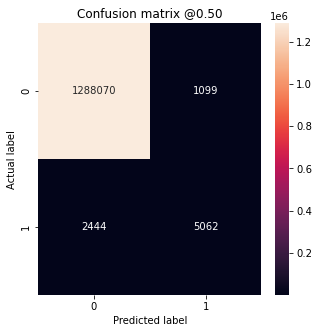

In [21]:
#replace the string passed into the function with the location of your data
predictionModel('https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/fraudTrain.csv.zip')

I pretty much followed the link in the assignment for much of the work. I attempted to use the keras tuner, but it didn't seem to help all that much. For the imbalance in the data, I calculated an output layer bias to use for the model, which was Log(Positive/Negative). I also increased the class weights for the positive class, ending up with a 100:1 boost. For the latitude and longitude, I calculated the distance from the merchant to their home location, as a higher than normal distance would likely indicate fraud. For the age of the theoretical person using the credit card, as it could be a fraud indicator with what purchases the card is making. 

For network structure, I used two dense layers, each with 5 times the amount of expected inputs, then a dropout layer dropping 20%, then two more dense layers at half of the neurons in the first dense layers, followed by another dropout layer, and finally a single output neuron using a sigmoid activation function. I feature selected out most of the string information from the original data, like street, name, state, and so on. I also used a standard scaler to scale the numeric values, which helped the recall greatly. I used the two dropout layers to avoid overfitting the data.